In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pydaptivefiltering as pdf

In [2]:
# --- 1. CONFIGURAÇÃO DO SISTEMA NÃO LINEAR ---
np.random.seed(42)
n_samples = 3000
memory_L = 4  # Memória linear (L)

# Entrada real (ruído branco gaussiano unitário)
x = np.random.randn(n_samples)

# Planta Desconhecida: Sistema Volterra de 2ª ordem fixo
# d[k] = 0.5*x[k] - 0.2*x[k-1] + 0.3*x[k]^2 + 0.1*x[k]x[k-1] + ruído
d = np.zeros(n_samples)
for k in range(1, n_samples):
    # Termos lineares
    linear = 0.5 * x[k] - 0.2 * x[k-memory_L+1]
    # Termos quadráticos
    quadratic = 0.3 * (x[k]**2) + 0.15 * x[k] * x[k-1]
    d[k] = linear + quadratic

# Adiciona ruído de medição (SNR alta)
d += 0.01 * np.random.randn(n_samples)

# --- 2. EXECUÇÃO DO FILTRO VOLTERRA LMS ---
# O número total de coeficientes será L + L(L+1)/2 = 4 + 4(5)/2 = 14
filt = pdf.VolterraLMS(
    memory=memory_L,
    step_size=0.01  # Passo de adaptação (mu)
)

result = filt.optimize(x, d, verbose=True, return_internal_states=True)

[VolterraLMS] Completed in 16.640 ms


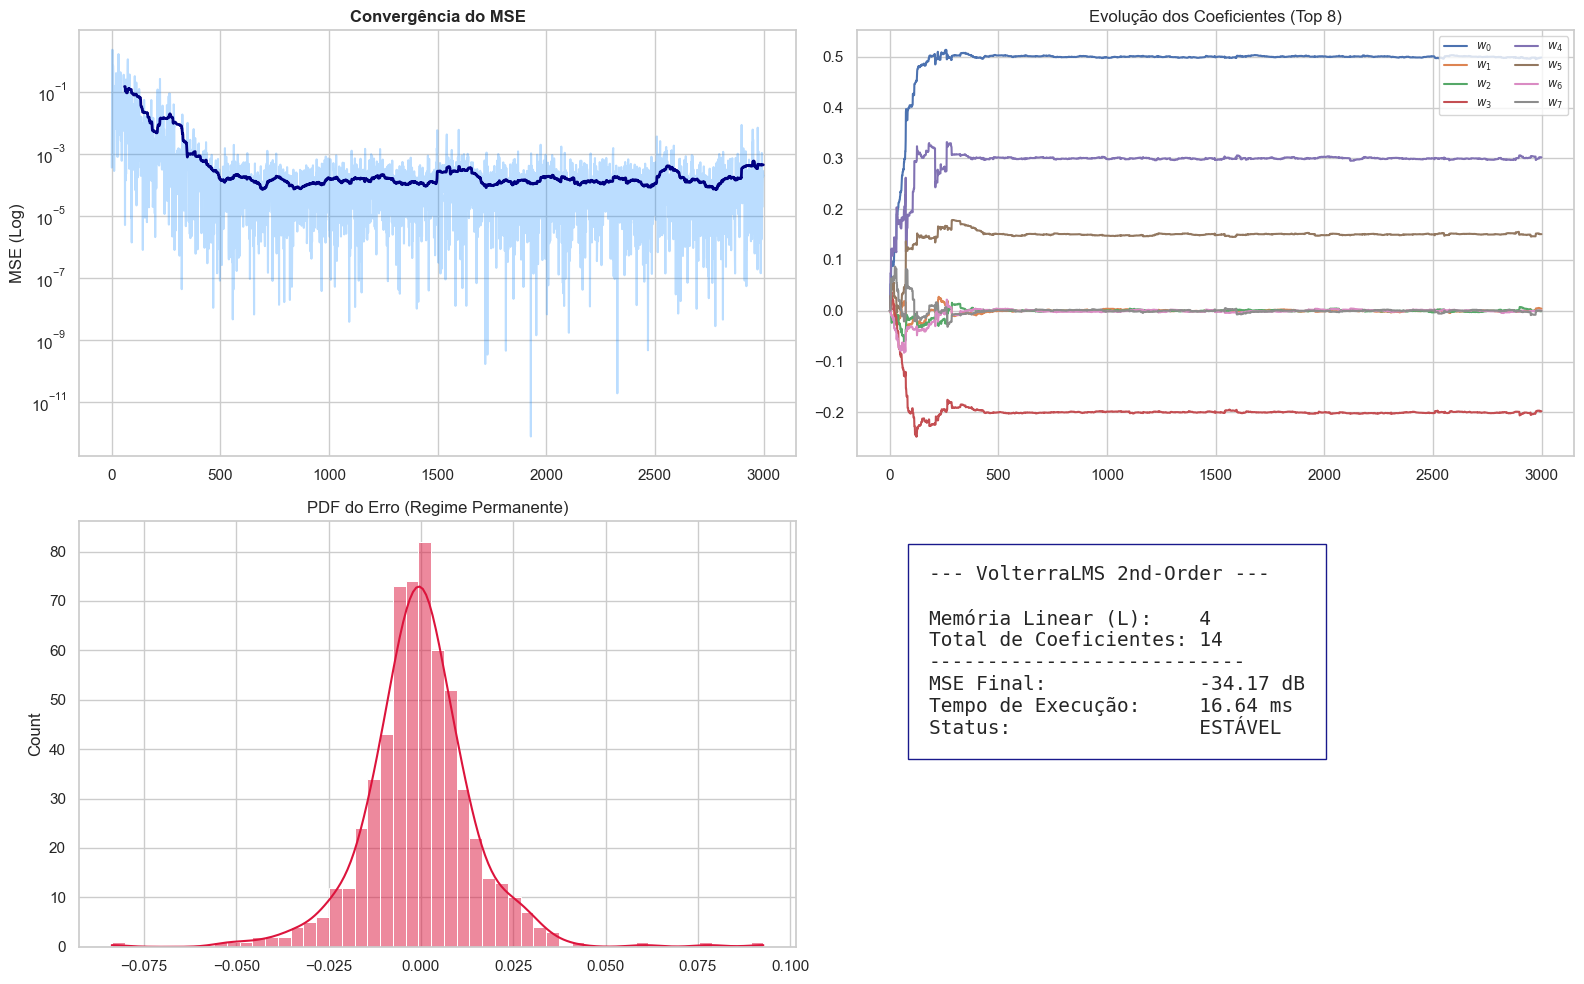

In [3]:
def plot_volterra_dashboard(result, title="Volterra LMS Analysis"):
    sns.set_theme(style="whitegrid")
    
    # 1. Extração de dados
    mse = result.mse()
    err = result.errors
    # Convertendo lista de histórico para matriz (N+1, n_coeffs)
    coeffs = np.array(result.coefficients)
    
    # AJUSTE DE DIMENSÃO: 
    # Se o sinal tem N amostras, o histórico tem N+1 (inclui w inicial)
    # Vamos usar do índice 1 em diante para alinhar com o tempo do sinal
    coeffs_to_plot = coeffs[1:] 
    t = np.arange(len(mse)) 
    
    # 2. Acesso ao tempo de execução
    execution_time = getattr(result, 'runtime_ms', 0)

    # 3. Extração de informações do dicionário extra
    extra = getattr(result, 'extra', {})
    n_coeffs = extra.get("n_coeffs", "N/A")
    memory_l = extra.get("memory", "N/A")
    
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(2, 2)

    # --- A. CURVA DE APRENDIZADO ---
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.semilogy(t, mse, alpha=0.3, color='dodgerblue')
    mse_smooth = pd.Series(mse).rolling(window=max(1, len(mse)//50)).mean()
    ax1.semilogy(t, mse_smooth, color='navy', lw=2)
    ax1.set_title("Convergência do MSE", fontweight='bold')
    ax1.set_ylabel("MSE (Log)")

    # --- B. TRAJETÓRIA DOS COEFICIENTES (ALINHADO) ---
    ax2 = fig.add_subplot(gs[0, 1])
    n_plot = min(coeffs_to_plot.shape[1], 8)
    for i in range(n_plot):
        # Agora t (3000,) e coeffs_to_plot (3000, n_coeffs) batem!
        ax2.plot(t, coeffs_to_plot[:, i], label=f'$w_{{{i}}}$')
    ax2.set_title(f"Evolução dos Coeficientes (Top {n_plot})")
    ax2.legend(loc='upper right', fontsize='x-small', ncol=2)

    # --- C. DISTRIBUIÇÃO DO ERRO ---
    ax3 = fig.add_subplot(gs[1, 0])
    steady_state_err = err[-int(len(err)*0.2):].real
    sns.histplot(steady_state_err, kde=True, ax=ax3, color="crimson")
    ax3.set_title("PDF do Erro (Regime Permanente)")

    # --- D. QUADRO DE RESUMO ---
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.axis('off')
    
    final_mse_db = 10 * np.log10(np.mean(mse[-100:]))
    
    stats_text = (
        f"--- {title} ---\n\n"
        f"Memória Linear (L):    {memory_l}\n"
        f"Total de Coeficientes: {n_coeffs}\n"
        f"---------------------------\n"
        f"MSE Final:             {final_mse_db:.2f} dB\n"
        f"Tempo de Execução:     {execution_time:.2f} ms\n"
        f"Status:                {'ESTÁVEL' if not np.isnan(mse[-1]) else 'DIVERGIU'}"
    )
    ax4.text(0.1, 0.5, stats_text, fontsize=14, family='monospace', 
             bbox=dict(facecolor='white', alpha=0.9, edgecolor='navy', pad=15))

    plt.tight_layout()
    plt.show()

plot_volterra_dashboard(result, "VolterraLMS 2nd-Order")